**Комментарий ревьюера**

Миша , снова привет! Меня зовут Сергей Волков, я буду проверять интересный  проект по временным рядам. Если не против, давай общаться на «ты». Если это неудобно, дай знать, перейдем на «вы».

У тебя проделана большая работа над проектом, но давай сделаем его еще лучше. Дальше ты найдешь мои комментарии — пожалуйста, не перемещай и не удаляй их. Буду использовать цветовую разметку:

<div class="alert alert-danger">
<b>Комментарий ревьюера:</b>  ❌красный текст - так выделены самые важные замечания. Без их отработки проект не будет принят. </div>

<div class="alert alert-warning">
<b>Комментарий ревьюера:</b>⚠️оранжевый текст - есть рекомендации, на что стоит обратить внимание. Так выделены небольшие замечания. Одно-два таких замечания в проекте допустимы, но если их будет больше - тебе будет необходимо внести исправления. </div>

<div class="alert alert-success">
<b>Комментарий ревьюера:</b> ✔️зеленый текст - все отлично.</div>

Давай работать над проектом в диалоге: если ты что-то меняешь в проекте или отвечаешь на мои комментарии — пиши об этом. Мне будет легче отследить изменения, если ты выделишь свои комментарии:
<div class="alert alert-info"> <b>Комментарий студента:</b> Например, вот так.</div>

</div>
Всё это поможет выполнить повторную проверку твоего проекта оперативнее. 

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Ресемплирование</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Создание признаков</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import os

import numpy as np
from scipy.stats import poisson
from scipy.stats import norm

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

import seaborn as sns
sns.set_context('notebook', font_scale=1.5)
sns.set_style('darkgrid', rc={'ytick.left':True, 'ytick.direction':'in',
                              'xtick.bottom':True, 'xtick.direction':'in'})

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

## Подготовка

In [2]:
def get_data(filename):
    
    """
    Reads the data from the given path.
    """

    pth1 = f'/datasets/{filename}'
    pth2 = f'data/{filename}'

    if os.path.exists(pth1):
        df = pd.read_csv(pth1, parse_dates=['datetime'], index_col='datetime')
        print(f'Reading {pth1}...')
    elif os.path.exists(pth2):
        df = pd.read_csv(pth2, parse_dates=['datetime'], index_col='datetime')
        print(f'Reading {pth2}...')
    else:
        print('Check the file path')

    return df

In [3]:
file_name = 'taxi.csv'
df = get_data(file_name)
df.sort_index(inplace=True)

df.head()

Reading data/taxi.csv...


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


## Анализ

In [5]:
np.unique(np.diff(df.index))[0].astype('timedelta64[m]')

numpy.timedelta64(10,'m')

Статистика собрана для одинаковых интервалов (10 минут).

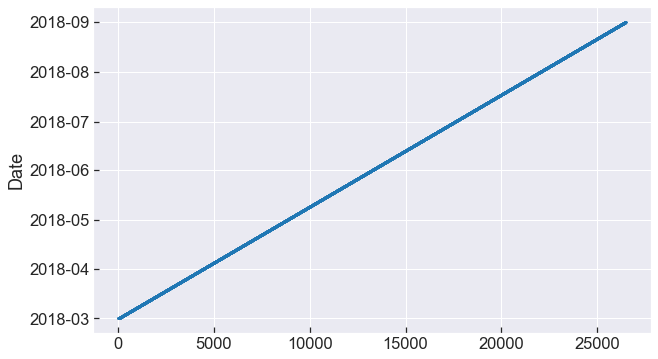

In [6]:
plt.scatter(np.arange(len(df)), df.index, s=1)

plt.ylabel('Date')

plt.show()

Данные представлены с марта по сентябрь 2018 года и отсортированы по возрастанию даты.

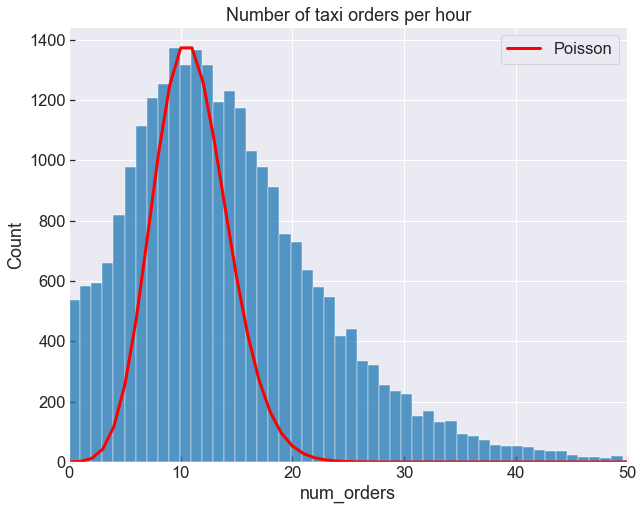

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.histplot(df['num_orders'], bins=120, ax=ax)

k = np.arange(60)
# Нормировку и среднее подбираю на глаз
poisson_k = 1.15e4 * poisson.pmf(k, 11)

ax.plot(k, poisson_k, 'r', label='Poisson', lw=3)
ax.legend()

ax.set_xlim(0, 50)
ax.set_title('Number of taxi orders per hour')

plt.show()

Откуда такие отклонения от Пуассона? Кажется, что это должен быть классический пример распределения. Может быть $\mu$ изменяется во времени и данные получится описать совокупностью Пуассоновских распределений?

In [8]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [9]:
df.isna().sum()

num_orders    0
dtype: int64

Медианное значение $-$ 14 заказов за 10 минут.

### Ресемплирование

In [10]:
df = df.resample('1H').sum()

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43



<div class="alert alert-success">
<b>Комментарий ревьюера:</b> ✔️Отлично. Расемплирование проще всего интерпритируется с интерпритируется sum()</div>

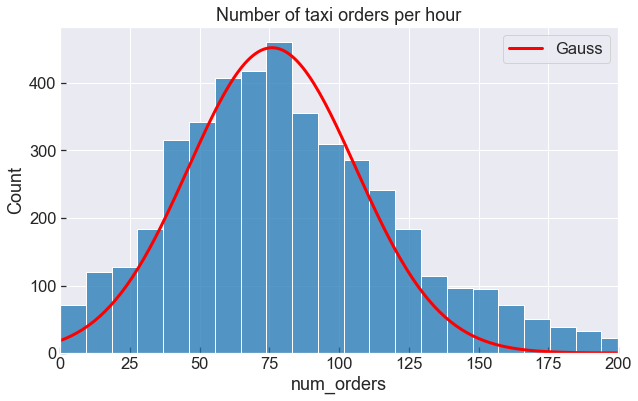

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(df['num_orders'], bins=50, ax=ax)

k = np.arange(300)
# Нормировку и среднее подбираю на глаз
poisson_k = 3.4e4 * norm.pdf(k, loc=df['num_orders'].mean() * .9, scale=30)

ax.plot(k, poisson_k, 'r', label='Gauss', lw=3)
ax.legend()

ax.set_xlim(0, 200)
ax.set_title('Number of taxi orders per hour')

plt.show()

После ресемплирования распределения стало больше походить на нормальное.

In [12]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


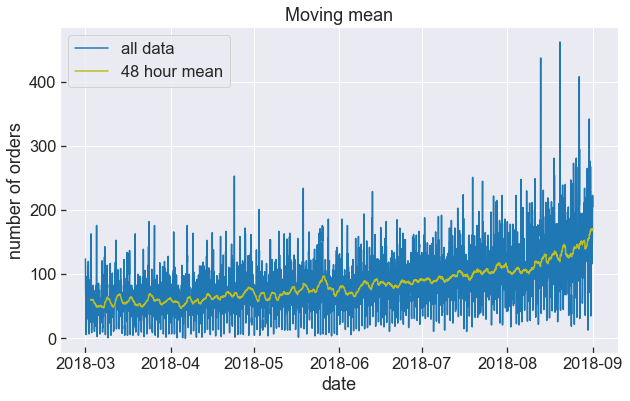

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df, label='all data')

ax.plot(df.rolling(48).mean(), color='C8',
        label='48 hour mean', zorder=3)

plt.legend()

plt.title('Moving mean')
plt.ylabel('number of orders')
plt.xlabel('date')

plt.show()

Действительно, среднее значение растет с каждим месяцем. Возможно, это объясняет отличие итогового распределения от Пуассона с фиксированным матожиданием.

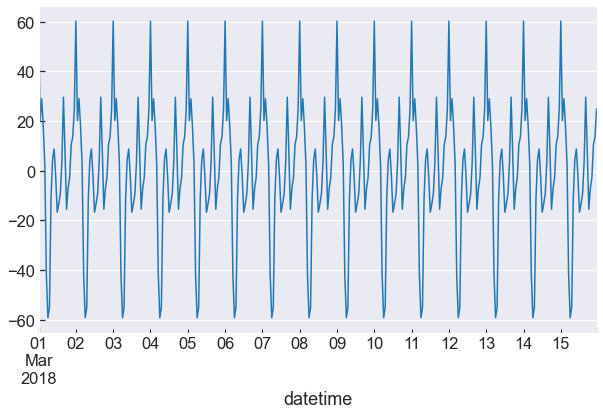

In [14]:
decomposed = seasonal_decompose(df)

decomposed.seasonal['2018-03-01':'2018-03-15'].plot()

plt.show()

В данных прослеживается  часовая сезонность

### Создание признаков

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # Скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(df, 24, 48)

<div class="alert alert-warning">
<b>Комментарий ревьюера:</b>⚠️Тяжело создавтьпризнаки без выявления сезонностей и трендов, именно основываясь на них, мы исоздаем признаки, в тренажере вам давали  seasonal_decompose(), вот эта функция с разными интервалами времени помогает выявитьсезонности.

Сезонности бывают:
    
Годовая - нам не подходит, т.к. данные за пол года.
    
Месячная - изменение кол-во заковов в зависимости от месяца.
    
Недельная - в субботу больше, чем в понедельник
    
Часовая - утром больше или меньше, чем вечером.

Вотодногопризнака точно не хватает.
</div>

<div class="alert alert-block alert-warning">
<b> Комментарий студента #2</b>
    
Построил декомпозицию, добавил часы в признаки

</div>

In [16]:
df.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Обучение

### Линейная регрессия

In [17]:
train, test = train_test_split(df, shuffle=False,
                               test_size=.1, random_state=42)

train = train.dropna()

train.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,3,3,5,0,72.0,119.0,101.0,93.0,49.0,...,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,59.791667
2018-03-03 01:00:00,108,3,3,5,1,163.0,72.0,119.0,101.0,93.0,...,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,60.604167
2018-03-03 02:00:00,25,3,3,5,2,108.0,163.0,72.0,119.0,101.0,...,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,61.083333
2018-03-03 03:00:00,64,3,3,5,3,25.0,108.0,163.0,72.0,119.0,...,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,60.125000
2018-03-03 04:00:00,44,3,3,5,4,64.0,25.0,108.0,163.0,72.0,...,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,60.083333


In [18]:
train.index.dayofweek.unique()

Int64Index([5, 6, 0, 1, 2, 3, 4], dtype='int64', name='datetime')

In [19]:
X_test, X_train = test.drop(columns='num_orders'), train.drop(columns='num_orders')
y_test, y_train = test['num_orders'], train['num_orders']

# Scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

lin_model = LinearRegression()

In [20]:
%time
lin_model.fit(X_train, y_train)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs


LinearRegression()

In [21]:

lin_test_predictions = lin_model.predict(X_test)
lin_train_predictions = lin_model.predict(X_train)

### LGBM

In [22]:
lgbm_model = LGBMRegressor(random_state=42, metric='rmse')

In [23]:
%%time
lgbm_model.fit(X_train, y_train)

CPU times: user 909 ms, sys: 130 ms, total: 1.04 s
Wall time: 157 ms


LGBMRegressor(metric='rmse', random_state=42)

In [24]:
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'rmse'}

In [25]:
param_grid = {
    'num_leaves': np.arange(10, 100, 5),
    'min_data_in_leaf': np.arange(10, 500, 10)
    }


In [26]:
tscv = TimeSeriesSplit(n_splits=3, test_size=5)

In [27]:
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_grid,
    n_iter=20,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=50,
    random_state=42
)

In [28]:
%%time
random_search_lgbm.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3; 1/20] START min_data_in_leaf=30, num_leaves=50.........................
[CV 1/3; 1/20] END min_data_in_leaf=30, num_leaves=50;, score=-137.951 total time=   0.3s
[CV 2/3; 1/20] START min_data_in_leaf=30, num_leaves=50.........................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[CV 2/3; 1/20] END min_data_in_leaf=30, num_leaves=50;, score=-19.247 total time=   0.2s
[CV 3/3; 1/20] START min_data_in_leaf=30, num_leaves=50.........................
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[CV 3/3; 1/20] END min_data_in_leaf=30, num_leaves=50;, score=-16.246 total time=   0.2s
[CV 1/3; 2/20] START min_data_in_leaf=190, num_leaves=60........................
[LightGBM] [Warning] min_data_in_leaf is set=190, min_child_samples=20 will be ignored. Current value: 

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=5),
                   estimator=LGBMRegressor(metric='rmse', random_state=42),
                   n_iter=20,
                   param_distributions={'min_data_in_leaf': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490]),
                                        'num_leaves': array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90,
       95])},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=50)

In [29]:
-random_search_lgbm.best_score_

56.27423922159165

In [30]:
random_search_lgbm.best_params_

{'num_leaves': 80, 'min_data_in_leaf': 50}

## Тестирование

In [31]:
lin_test_predictions = lin_model.predict(X_test)
lin_train_predictions = lin_model.predict(X_train)

print('Linear regression')
print(f"RMSE обучающей выборки: {mse(y_train, lin_train_predictions) ** .5:.1f}")
print(f"RMSE тестовой выборки:  {mse(y_test, lin_test_predictions) ** .5:.1f}")

Linear regression
RMSE обучающей выборки: 25.7
RMSE тестовой выборки:  47.2


In [32]:
print('LGBM')
lgbm_predictions_train = lgbm_model.predict(X_train)
lgbm_rmse_train = mse(y_train, lgbm_predictions_train) ** 0.5
print(f'LGBM RMSE: {lgbm_rmse_train:.1f}')

lgbm_minimal_predictions_test = lgbm_model.predict(X_test)
lgbm_rmse_test = mse(y_test, lgbm_minimal_predictions_test) ** 0.5
print(f'LGBM RMSE: {lgbm_rmse_test:.1f}')

LGBM
LGBM RMSE: 12.1
LGBM RMSE: 41.7


In [33]:
lgbm_train_predictions = random_search_lgbm.predict(X_train)
lgbm_test_predictions = random_search_lgbm.predict(X_test)

print('LGBM randomised search')
print(f"RMSE обучающей выборки: {mse(y_train, lgbm_train_predictions) ** .5:.1f}")
print(f"RMSE тестовой выборки:  {mse(y_test, lgbm_test_predictions) ** .5:.1f}")

LGBM randomised search
RMSE обучающей выборки: 10.2
RMSE тестовой выборки:  42.9


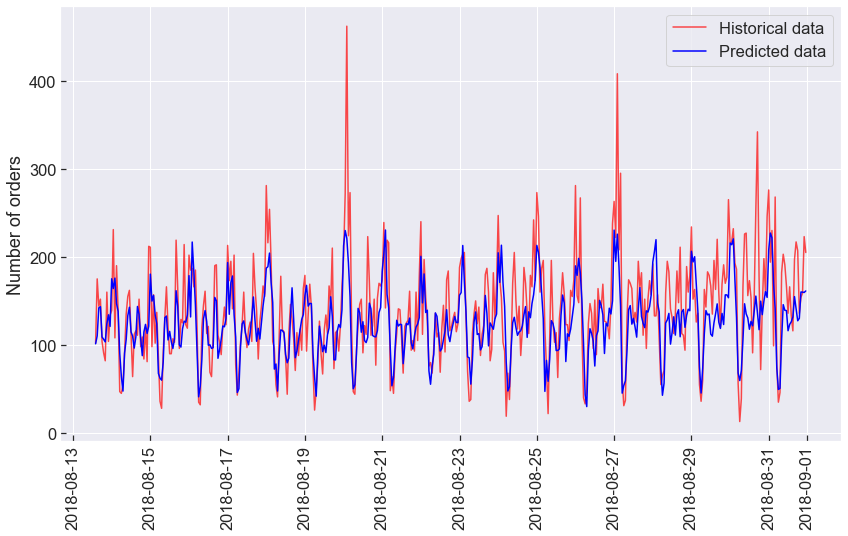

In [35]:
plt.figure(figsize=(14, 8))

plt.plot(y_test, color='red', label = 'Historical data', alpha=.7)
plt.plot(y_test.index, lgbm_minimal_predictions_test, color='blue', label='Predicted data')

plt.legend()
plt.xticks(rotation=90)
plt.ylabel('Number of orders')
    
plt.show()

## Вывод

Для прогнозирования количества заказов такси на следующий час были построены три модели. Модели были обучены на данных с марта по сентябрь 2018 года. Все три модели показывают результат лучше требуемого ($\text{RMSE} < 48$) на тестовых данных. Наилучшый результат $\text{RMSE} = 41.7$.

<div class="alert alert-block alert-warning">
<b> Комментарий студента</b>
    
Что я делаю не так с randomized search? Результат получается даже чуть хуже, чем для LGBM из коробки.

</div>


<div class="alert alert-danger">
    
<b>Комментарий ревьюера:</b>  ❌Такой результат получается, потому что идет переобучение, а переобучение из-за того, что используешьобычную кросс-валидацию, а она премешивает выборки, что во временных рядах нельзя делать, мы не должны "подглядывать в будщее", нужно или использоватьобычную валидацию или если используешьалгоритм подбора, тогда нужно в cv передавать кросс-валидацию для временных рядов TimeSeriesSplitt вот её пример https://medium.com/keita-starts-data-science/time-series-split-with-scikit-learn-74f5be38489e </div>

<div class="alert alert-block alert-warning">
<b> Комментарий студента #2</b>
    
Переделал randomized search, добавил TimeSeriesSplit. Результат не улучшился. При этом после добавления часовой сезонности по твоему совету результат на LGBM из коробки стал еще чуть лучше.

</div>

<div class="alert alert-success">
    
<b>Итоговый комментарий ревьюера :</b>
  
  Миша ,хорошая работа получилась,спасибо тебе. Есть пару моментов которые нужно добавить:
    
- Анализ сезонностей, без него тяжело выявитьпризнаки, получается с пушки по воробьям.
- Защитится от переобучения, как я тебе написал.
- В идеале в конце отрисовать график работы модели, пример тоже оставлю.
- Оставлюстатью, можетпотом почитаешь. https://habr.com/ru/company/ods/blog/327242/. 
    
    P.S. Я так понимаю дедлайн горит, отправишь работу, пустьменя куратор пинганет, чтоб я оперативно глянул её. 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48